In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
c = 2
n_prices = 100
price_grid = np.linspace(0.01, 10, n_prices)
alpha = 0.1
T_async = 5000
T_sync = 500

def get_demand(p_i, p_j):
    if p_i < p_j and p_i <= 10:
        return 1
    elif p_i == p_j and p_i <= 10:
        return 0.5
    else:
        return 0

class PricingAgent:
    def __init__(self, price_grid, alpha=0.1, init_range=(10, 20)):
        self.price_grid = price_grid
        self.alpha = alpha
        self.W = np.random.uniform(init_range[0], init_range[1], len(price_grid))
    
    def choose_price(self):
        return np.argmax(self.W)

def update_async(agent, chosen_idx, profit):
    agent.W[chosen_idx] = agent.alpha * profit + (1 - agent.alpha) * agent.W[chosen_idx]

def update_sync_perfect(agent, opponent_price_idx, cost):
    p_j = price_grid[opponent_price_idx]
    for i, p_i in enumerate(price_grid):
        demand = get_demand(p_i, p_j)
        profit = (p_i - cost) * demand
        agent.W[i] = agent.alpha * profit + (1 - agent.alpha) * agent.W[i]

def update_sync_downward(agent, opponent_price_idx, chosen_idx, profit_actual, cost):
    p_j = price_grid[opponent_price_idx]
    q_actual = get_demand(price_grid[chosen_idx], p_j)
    for i, p in enumerate(price_grid):
        if i == chosen_idx:
            agent.W[i] = agent.alpha * profit_actual + (1 - agent.alpha) * agent.W[i]
        else:
            profit_est = (p - cost) * q_actual
            if (p > price_grid[chosen_idx] and agent.W[i] > profit_est) or \
               (p < price_grid[chosen_idx] and profit_est > agent.W[i]):
                agent.W[i] = agent.alpha * profit_est + (1 - agent.alpha) * agent.W[i]

def run_simulation(update_fn, T):
    agent1 = PricingAgent(price_grid, alpha)
    agent2 = PricingAgent(price_grid, alpha)
    price_history = []

    for _ in range(T):
        idx1 = agent1.choose_price()
        idx2 = agent2.choose_price()
        p1 = price_grid[idx1]
        p2 = price_grid[idx2]

        d1 = get_demand(p1, p2)
        d2 = get_demand(p2, p1)

        profit1 = (p1 - c) * d1
        profit2 = (p2 - c) * d2

        update_fn(agent1, idx2, idx1, profit1, c)
        update_fn(agent2, idx1, idx2, profit2, c)

        price_history.append(p1)  # only firm 1 for percentile tracking
    
    return price_history

def simulate_batch(update_fn, T, runs=100):
    results = []
    for _ in range(runs):
        history = run_simulation(update_fn, T)
        results.append(history)
    return np.array(results)

# Wrappers for update protocols
def async_wrapper(agent, opponent_idx, chosen_idx, profit, cost):
    update_async(agent, chosen_idx, profit)

def perfect_sync_wrapper(agent, opponent_idx, chosen_idx, profit, cost):
    update_sync_perfect(agent, opponent_idx, cost)

def down_slope_wrapper(agent, opponent_idx, chosen_idx, profit, cost):
    update_sync_downward(agent, opponent_idx, chosen_idx, profit, cost)

# Run batches
np.random.seed(0)
async_results = simulate_batch(async_wrapper, T_async)
perfect_sync_results = simulate_batch(perfect_sync_wrapper, T_sync)
downward_results = simulate_batch(down_slope_wrapper, T_sync)

async_percentiles = np.percentile(async_results, [0, 25, 50, 75, 100], axis=0)
perfect_sync_percentiles = np.percentile(perfect_sync_results, [0, 25, 50, 75, 100], axis=0)
downward_percentiles = np.percentile(downward_results, [0, 25, 50, 75, 100], axis=0)

async_percentiles.shape, perfect_sync_percentiles.shape, downward_percentiles.shape

((5, 5000), (5, 500), (5, 500))

In [11]:
def plot_percentiles(percentiles, T, title):
    """
    Plot percentile lines for simulation results.

    Parameters:
        percentiles (np.array): 2D array of shape (5, T), representing
                                min, 25%, 50%, 75%, max over time.
        T (int): Number of periods in the simulation.
        title (str): Title of the plot.
    """
    x = np.arange(T)
    plt.figure(figsize=(10, 4))
    plt.plot(x, percentiles[0], 'k-', linewidth=1, label='Min')
    plt.plot(x, percentiles[1], 'gray', linestyle='--', linewidth=1, label='25th percentile')
    plt.plot(x, percentiles[2], 'k-', linewidth=2, label='Median')
    plt.plot(x, percentiles[3], 'gray', linestyle='--', linewidth=1, label='75th percentile')
    plt.plot(x, percentiles[4], 'k-', linewidth=1, label='Max')
    plt.title(title)
    plt.xlabel("Period")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


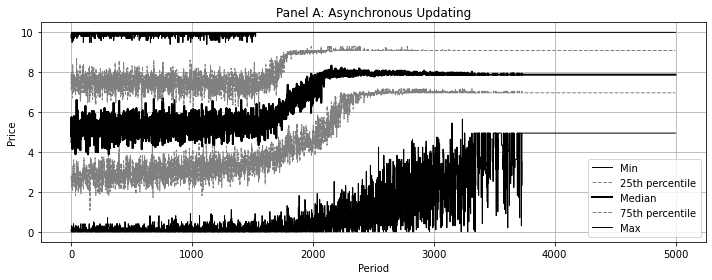

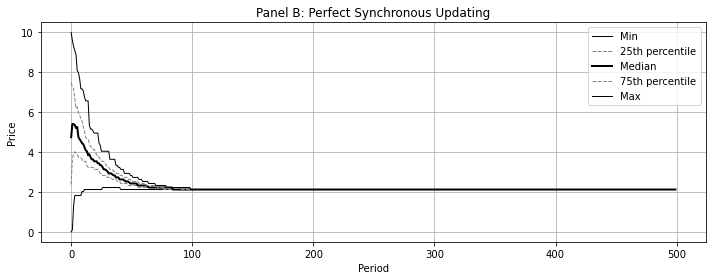

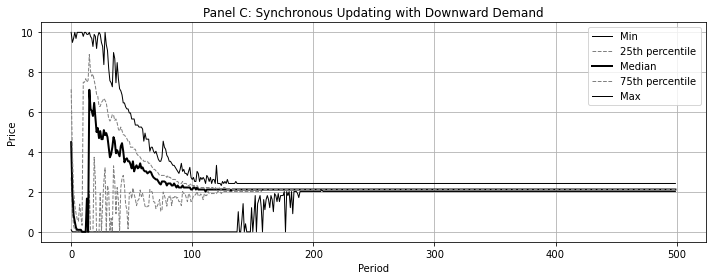

In [12]:
plot_percentiles(async_percentiles, T_async, "Panel A: Asynchronous Updating")
plot_percentiles(perfect_sync_percentiles, T_sync, "Panel B: Perfect Synchronous Updating")
plot_percentiles(downward_percentiles, T_sync, "Panel C: Synchronous Updating with Downward Demand")
